In [1]:
import sys
sys.path.insert(0, '../../../')

# Base packages
import numpy as np
import matplotlib.pyplot as plt
import skimage
import scipy
from scipy import ndimage as ndi
import matplotlib.colors
import cv2

# Included in anaconda
import glob
import os

# External packages
from moviepy.editor import *
import hyperspy.api as hs
from tqdm import tqdm
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
from temnn.knet import MSDnet, Unet
from temnn.data.mods import local_normalize

from stm.feature.peaks import find_local_peaks

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 22})

# Specify GPU for Network Predictions

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"]="3"

# Functions

We will be working with hyperspy objects to make use of their many functionalities.

In [3]:
def to_hs(im_array,im_ref):
    '''
    Function to convert a numpy array (im_array) into a hyperspy object 
    and set scale equal to that of a previously defined hyperspy object (im_ref)
    
    Returns a calibrated hyperspy object im_cal
    '''
    im_cal=hs.signals.Signal2D(im_array)
    
    im_cal.axes_manager.signal_axes[0].scale=im_ref.axes_manager.signal_axes[0].scale
    im_cal.axes_manager.signal_axes[1].scale=im_ref.axes_manager.signal_axes[1].scale

    im_cal.axes_manager.signal_axes[0].units=im_ref.axes_manager.signal_axes[0].units
    im_cal.axes_manager.signal_axes[1].units=im_ref.axes_manager.signal_axes[1].units
    
    return im_cal

We will likely be calculating the dose a few times I've put it into a function, docstring below should explain it

In [4]:
def compute_dose_rate(
    intensity,brightness,
    area,exposure):
    '''
    Function to compute dose given intensity integrated over an area
    Brightness calibration and exposure time required
    
    Return dose in units of electrons per angstrom^2 per second
    '''
    dose_rate=(intensity*brightness_cal)/(area*exposure)/100
    
    return dose_rate

In [5]:
def expand_mask(mask, radius=10):
    expand = mask.copy()
    for j in range(radius,mask.shape[1]):
        for k in range(radius,mask.shape[2]):
            window = mask[0,j-radius:j+radius,k-radius:k+radius]
            fraction = np.count_nonzero(window == 1.0)/(window.shape[0]*window.shape[1])
            if fraction > 0.1:
                expand[0,j,k] = 1.0
    return expand

def crop_nanoparticle(img, infer):
    # Make the inference mask binary
    binary = infer[:,:,:,0].copy()
    binary[binary > 0.01] = 1.0
    
    # Expand the inference mask
    crop = expand_mask(binary)
    blur_level=200
    crop = cv2.blur(crop[0,:,:], (blur_level, blur_level))
    crop = crop.reshape((1,)+crop.shape+(1,))
    
    # Crop out nanoparticle
    img_crop = img*crop
    return img_crop, crop

def crop_substrate(img, infer):
    # Make the inference mask binary
    binary = infer[:,:,:,1].copy()
    binary[binary > 0.01] = 1.0
    
    # Expand the inference mask
    crop = expand_mask(binary)
    blur_level=200
    crop = cv2.blur(crop[0,:,:], (blur_level, blur_level))
    crop = crop.reshape((1,)+crop.shape+(1,))
    
    # Crop out nanoparticle
    img_crop = img*crop
    return img_crop, crop

def cover_nanoparticle(img, infer):
    # Make the inference mask binary
    binary = infer.copy()
    binary[binary > 0.01] = 1.0
    
    # Expand the inference mask
    crop = expand_mask(binary,radius=100)
    crop = skimage.util.invert(crop[0,:,:,0])
    blur_level=200
    crop = cv2.blur(crop, (blur_level, blur_level))
    crop = crop.reshape((1,)+crop.shape+(1,))
    
    # Crop out nanoparticle
    img_crop = img*crop
    return img_crop, crop

def trim_imagescale(img, percent=1):
    sorted_pixels = sorted(img.flatten())
    n = len(sorted_pixels)
    trim = int(n*percent/100)
    return sorted_pixels[trim: n-trim]

def fft(img):
    f = np.fft.fft2(img)
    f = np.fft.fftshift(f)
    cf = f.shape[0]/2,f.shape[1]/2
    f = f[int(cf[0]-80):int(cf[0]+80),int(cf[1]-80):int(cf[1]+80)]
    return np.log(np.abs(f)) #np.abs(f)

In [6]:
def block_centre(img):
    center = img.shape[0]/2,img.shape[1]/2
    blocked = img.copy()
    blocked[int(center[0]-10):int(center[0]+10),int(center[1]-10):int(center[1]+10)] = 0.0
    return blocked

def rot_mat(theta):
    r = np.array(( (np.cos(theta), -np.sin(theta)),
               (np.sin(theta),  np.cos(theta)) ))
    return r

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    if phi < 0:
        phi += 2*np.pi
    return rho, phi

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

I have trained Neural networks to do both multiclass and single class segmentation, so for plotting purposes toggle the boolean below.

In [7]:
multiclass = False

# Load data

In [8]:
folder='../../experimental_data/wibang/20201201_ETEM_MEMS6/ROI1'
doserate='DR2_AuNP1_ADC'
files=glob.glob(r'{}/{}/Hour_00/Minute_*/Second_*/*.dm4'.format(folder,doserate))
# We can output the filenames gathered by glob to make sure they are correct
#files

In [9]:
if multiclass:
    output_dir='{}/nanoparticle_multiclass_processing_output'.format(folder)
else:
    output_dir='{}/nanoparticle_singleclass_processing_output'.format(folder)
# Check if an output folder exists first, if not then creates one (will only create one the first time for a new dataset)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [10]:
if not os.path.exists('{}/stack_{}.hspy'.format(output_dir,doserate)):
    i=hs.load(files,lazy=True,stack=True)

In [11]:
if not os.path.exists('{}/stack_{}.hspy'.format(output_dir,doserate)):
    # Saving the whole stack as a hyperspy object in this new output folder (you could do this as a tif or hdf5)
    # This is smaller than the combination of all the dm4 files
    i.save('{}/stack_{}.hspy'.format(output_dir,doserate),overwrite=True)

In [12]:
# Now I can load the hyperspy file rather than use the lazy-loaded individual files
i=hs.load('{}/stack_{}.hspy'.format(output_dir,doserate),lazy=False)

In [13]:
# This is because we loaded the data as a stack. The stack metadata has each individual frame's metadata
# The original data is in a 'DictionaryTree' but we want to loop through it
# So I am converting it to a standard Python dictionary
stack_metadata=i.original_metadata.stack_elements.as_dictionary()

# An individual frame's metadata is then:
frame_index=0
frame_metadata=stack_metadata['element{}'.format(frame_index)]

In [14]:
i.axes_manager.navigation_axes[0].scale=frame_metadata['original_metadata']['ImageList']['TagGroup0']['ImageTags']['DataBar']['Exposure Time (s)']
i.axes_manager.navigation_axes[0].units='s'
i.axes_manager.navigation_axes[0].name='t'
i.axes_manager

<Axes manager, axes: (185|857, 794)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               t |    185 |      0 |       0 |     0.2 |      s 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |    857 |        |      -0 |  0.0073 |     nm 
               y |    794 |        |      -0 |  0.0073 |     nm

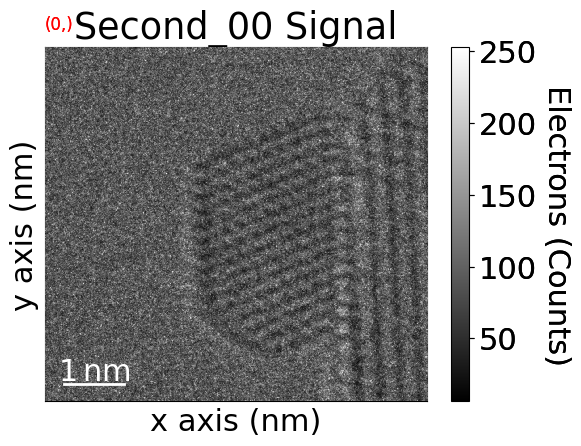

In [15]:
i.plot(navigator='slider')
plt.show()

In [16]:
x_cal,y_cal=i.axes_manager.signal_axes[0].scale,i.axes_manager.signal_axes[1].scale
x_size,y_size=i.axes_manager.signal_axes[0].size,i.axes_manager.signal_axes[1].size

x_nm,y_nm=x_cal*x_size,y_cal*y_size

# Calculate dose rates

In [17]:
im=to_hs(i.data,i)

In [18]:
brightness_cal=frame_metadata['original_metadata']['ImageList']['TagGroup0']['ImageData']['Calibrations']['Brightness']['Scale']
exposure=frame_metadata['original_metadata']['ImageList']['TagGroup0']['ImageTags']['DataBar']['Exposure Time (s)']

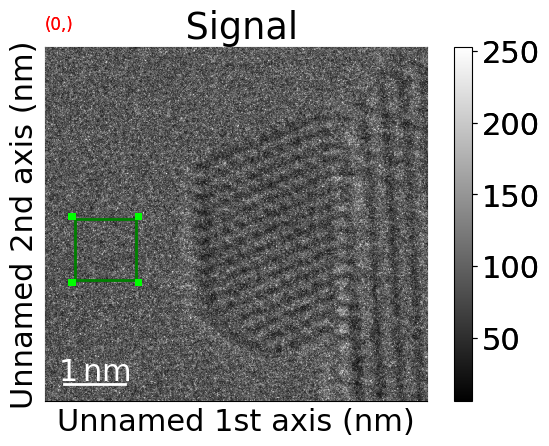

In [19]:
# You can play around with these values and shift it wherever you want, you can even drag it around on the plot
rect=hs.roi.RectangularROI(left=0.5,right=1.5,top=y_nm-3, bottom=y_nm-2)
im.plot(navigator='slider')
roi=rect.interactive(im)
plt.show()

In [20]:
roi_data=roi.data
dose_rate_list=[]
area=roi.inav[0].data.shape[0]*roi.inav[0].data.shape[1]*(x_cal*y_cal)

for n in tqdm(range(0,roi_data.shape[0])):
    dose_rate_list.append(compute_dose_rate(roi_data[n].sum(),brightness_cal,area,exposure))
dose_rates=np.array(dose_rate_list)

100%|██████████| 185/185 [00:00<00:00, 42127.49it/s]


In [21]:
doses=dose_rates*exposure

# Load Neural Network for image predictions

In [22]:
### Load trained neural network
n = 'MSDnet'
network = 'Au_fcc_mixed'
nnf = '../../{}_precomputed_trained_data/{}'.format(n,network) #Trained Neural net folder
nnf = glob.glob(os.path.join(nnf,'model-*'))[-1] # latest model
print("Using {} CNN model in".format(n), network)

mod = keras.models.load_model(nnf)

Using MSDnet CNN model in Au_fcc_mixed


# Analysis

Below I will work with a random example specified by 'frame_index' to test the result and formatting before running the loop over all frames

In [23]:
frame_dose_rate=dose_rates[frame_index]
frame_dose=doses[frame_index]
frame_cumulative_dose=np.sum(doses[0:frame_index+1])
frame_time=np.round(exposure*(frame_index+1),2)

assert x_cal == y_cal

normalizerange = 12.0/(x_cal*10)

img = local_normalize(im.data[frame_index], normalizerange, normalizerange)
img.shape = (1,) + img.shape + (1,)
infer = mod.predict(img)

# Cut out nanoparticle
imgcrop, crop = crop_nanoparticle(img, infer)

# Scale image distribution

To avoid dead/burning pixels shifting the contrast of the images displayed later I will scale every image remove the upper and lower 1% of the pixel value distribution. Here I visualise the cut.

In [24]:
trimmed_pixels = trim_imagescale(img)            # Trim away the upper and lower 1% (default)
scale = min(trimmed_pixels), max(trimmed_pixels) # Save the values to scale

# Plotting

In [25]:
imgcrop_ft = fft(imgcrop[0,:,:,0])

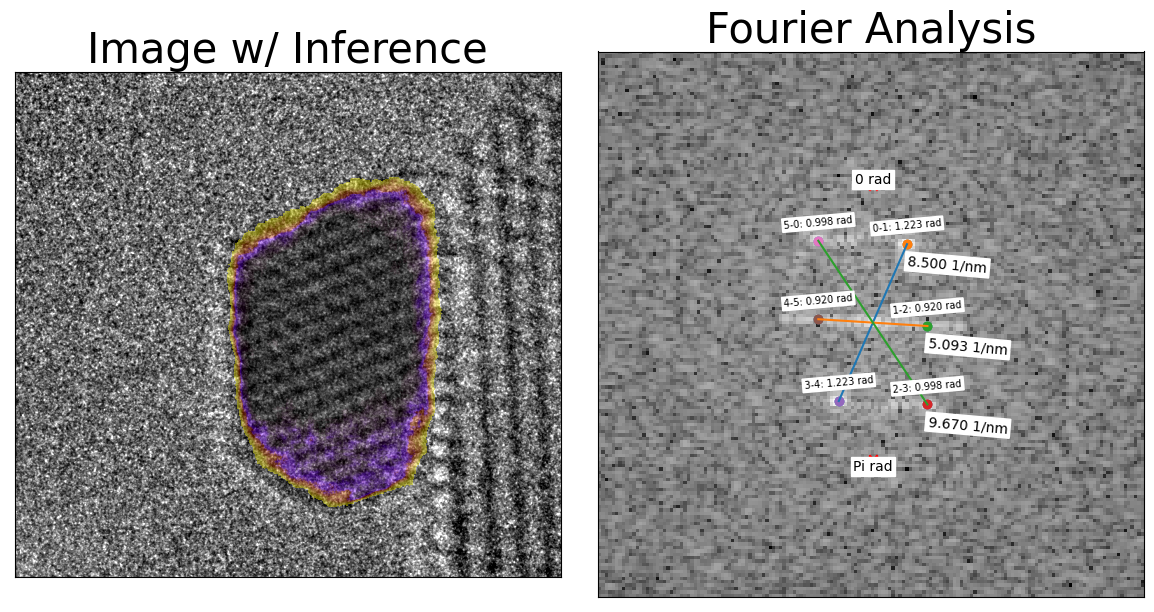

In [26]:
#imgcrop_ftnorm = block_centre(imgcrop_ft/np.max(imgcrop_ft))
imgcrop_ftnorm = block_centre(imgcrop_ft)

peaks = find_local_peaks(imgcrop_ftnorm,
                         min_distance=30,
                         threshold=0.8,
                         local_threshold=0,
                         exclude_adjacent=True)

fig,ax=plt.subplots(figsize=(12.0,8.0),nrows=1,ncols=2)

infermask = infer.copy()
infermask[infermask < 0.01] = np.nan
ax[0].imshow(img[0,:,:,0],cmap='gray',origin='lower',vmin=scale[0],vmax=scale[1])
ax[0].imshow(infermask[0,:,:,:],cmap='gnuplot_r',alpha=0.4)
ax[0].set_title("Image w/ Inference",fontsize=30)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(imgcrop_ft, cmap='gray',origin='lower')
ax[1].scatter(peaks[:,1], peaks[:,0])
### Obtain q-space sampling
freqx = np.fft.fftshift(np.fft.fftfreq(imgcrop.shape[1],d=x_cal))
freqy = np.fft.fftshift(np.fft.fftfreq(imgcrop.shape[2],d=y_cal))
sampling_qx = freqx[1] - freqx[0]
sampling_qy = freqy[1] - freqy[0]
sampling_q = sampling_qx

### Analysis and plot on nanoparticle Fourier spectrum

# Locate centre of points to centre origin
centroid = (sum(peaks[:,0]) / len(peaks), sum(peaks[:,1]) / len(peaks))
cpeaks = peaks - centroid
num_peaks = len(cpeaks)

# Tag where 0 and Pi rad are located
zero_x, zero_y = pol2cart(40,0)
ax[1].scatter(zero_y+centroid,zero_x+centroid,marker='x',c='r')
ax[1].text(zero_y+centroid[1], zero_x+centroid[0],
                   "0 rad",
                   backgroundcolor='w',
                   fontsize=10.0,
                   rotation=0,
                   horizontalalignment='center',
                   verticalalignment='bottom',
                   transform=ax[1].transData)
pi_x, pi_y = pol2cart(40,np.pi)
ax[1].scatter(pi_y+centroid,pi_x+centroid,marker='x',c='r')
ax[1].text(pi_y+centroid[1], pi_x+centroid[0],
                   "Pi rad",
                   backgroundcolor='w',
                   fontsize=10.0,
                   rotation=0,
                   horizontalalignment='center',
                   verticalalignment='top',
                   transform=ax[1].transData)

# Analyse spectrum
polarpeaks = np.zeros(cpeaks.shape)
# Convert all peaks from cartesian to polar coordinates
for i, peak in enumerate(cpeaks):
    polarpeaks[i,0], polarpeaks[i,1] = cart2pol(peak[0],peak[1])
# Sort the peaks by increasing angle
polarpeaks = np.array(sorted(polarpeaks,key=lambda x: x[1]))

# Analyse peaks
for i, polpeak1 in enumerate(polarpeaks):
    # Back to Cartesian for plotting
    cartpeak_x,cartpeak_y = pol2cart(polpeak1[0],polpeak1[1])
    ax[1].scatter(cartpeak_y+centroid,cartpeak_x+centroid)

    # For every peak, get the angle to the next peak
    if i < num_peaks-1:
        ang = np.diff([polpeak1[1],polarpeaks[i+1,1]])
        ax[1].text(cartpeak_y+centroid[1], cartpeak_x+centroid[0]+3,
                   "{}-{}: {:.3f} rad".format(i,i+1,ang[0]),
                   backgroundcolor='w',
                   fontsize=7.0,
                   rotation=5,
                   horizontalalignment='center',
                   verticalalignment='bottom',
                   transform=ax[1].transData)
    elif i == num_peaks-1:
        ang = [2*np.pi-polpeak1[1]+polarpeaks[0,1]]
        ax[1].text(cartpeak_y+centroid[1], cartpeak_x+centroid[0]+3,
                   "{}-{}: {:.3f} rad".format(i,0,ang[0]),
                   backgroundcolor='w',
                   fontsize=7.0,
                   rotation=5,
                   horizontalalignment='center',
                   verticalalignment='bottom',
                   transform=ax[1].transData)
    
    # For every peak, loop through all other peaks to find a symmetric peak
    for j, polpeak2 in enumerate(polarpeaks[i+1:]):
        # This if statement matches the length and symmetry (angle+Pi) of every point to find a symmetric pair
        if polpeak1[0] >= polpeak2[0]-0.01 and polpeak1[0] <= polpeak2[0]+0.01 and polpeak1[1]+np.pi >= polpeak2[1]-0.01 and polpeak1[1]+np.pi <= polpeak2[1]+0.01:
            # When a pair is found plot a line for visualisation
            cartp1_x, cartp1_y = pol2cart(polpeak1[0],polpeak1[1])
            cartp2_x, cartp2_y = pol2cart(polpeak2[0],polpeak2[1])
            x_values = [cartp1_x, cartp2_x]
            y_values = [cartp1_y, cartp2_y]
            # Also calculate the length between the points
            l = np.sqrt((np.diff(x_values)*sampling_qx)**2 + (np.diff(y_values)*sampling_qy)**2)
            ax[1].text(cartp1_y+centroid[1], cartp1_x+centroid[0]-3,
                       "{:.3f} 1/nm".format(l[0]),
                       backgroundcolor='w',
                       fontsize=10.0,
                       rotation=-5,
                       horizontalalignment='left',
                       verticalalignment='top',
                       transform=ax[1].transData)
            ax[1].plot(y_values+centroid[1],x_values+centroid[0])
ax[1].set_title("Fourier Analysis",fontsize=30)
ax[1].set_xticks([])
ax[1].set_yticks([])
####

plt.tight_layout()
plt.show()

In [27]:
for frame_index in tqdm(range(0,len(im))):
    
    frame_dose_rate=dose_rates[frame_index]
    frame_dose=doses[frame_index]
    frame_cumulative_dose=np.sum(doses[0:frame_index+1])
    frame_time=np.round(exposure*(frame_index+1),2)

    assert x_cal == y_cal

    normalizerange = 12.0/(x_cal*10)

    img = local_normalize(im.data[frame_index], normalizerange, normalizerange)
    img.shape = (1,) + img.shape + (1,)
    infer = mod.predict(img)

    # Cut out nanoparticle
    imgcrop, crop = crop_nanoparticle(img, infer)
    
    trimmed_pixels = trim_imagescale(img)            # Trim away the upper and lower 1% (default)
    scale = min(trimmed_pixels), max(trimmed_pixels) # Save the values to scale
    
    imgcrop_ft = fft(imgcrop[0,:,:,0])
    
    #imgcrop_ftnorm = block_centre(imgcrop_ft/np.max(imgcrop_ft))
    imgcrop_ftnorm = block_centre(imgcrop_ft)

    peaks = find_local_peaks(imgcrop_ftnorm,
                             min_distance=30,
                             threshold=0.8,
                             local_threshold=0,
                             exclude_adjacent=True)

    fig,ax=plt.subplots(figsize=(12.0,8.0),nrows=1,ncols=2)

    infermask = infer.copy()
    infermask[infermask < 0.01] = np.nan
    ax[0].imshow(img[0,:,:,0],cmap='gray',origin='lower',vmin=scale[0],vmax=scale[1])
    ax[0].imshow(infermask[0,:,:,:],cmap='gnuplot_r',alpha=0.4)
    ax[0].set_title("Image w/ Inference",fontsize=30)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(imgcrop_ft, cmap='gray',origin='lower')
    ax[1].scatter(peaks[:,1], peaks[:,0])
    ### Obtain q-space sampling
    freqx = np.fft.fftshift(np.fft.fftfreq(imgcrop.shape[1],d=x_cal))
    freqy = np.fft.fftshift(np.fft.fftfreq(imgcrop.shape[2],d=y_cal))
    sampling_qx = freqx[1] - freqx[0]
    sampling_qy = freqy[1] - freqy[0]
    sampling_q = sampling_qx

    ### Analysis and plot on nanoparticle Fourier spectrum

    # Locate centre of points to centre origin
    centroid = (sum(peaks[:,0]) / len(peaks), sum(peaks[:,1]) / len(peaks))
    cpeaks = peaks - centroid
    num_peaks = len(cpeaks)

    # Tag where 0 and Pi rad are located
    zero_x, zero_y = pol2cart(40,0)
    ax[1].scatter(zero_y+centroid,zero_x+centroid,marker='x',c='r')
    ax[1].text(zero_y+centroid[1], zero_x+centroid[0],
                       "0 rad",
                       backgroundcolor='w',
                       fontsize=10.0,
                       rotation=0,
                       horizontalalignment='center',
                       verticalalignment='bottom',
                       transform=ax[1].transData)
    pi_x, pi_y = pol2cart(40,np.pi)
    ax[1].scatter(pi_y+centroid,pi_x+centroid,marker='x',c='r')
    ax[1].text(pi_y+centroid[1], pi_x+centroid[0],
                       "Pi rad",
                       backgroundcolor='w',
                       fontsize=10.0,
                       rotation=0,
                       horizontalalignment='center',
                       verticalalignment='top',
                       transform=ax[1].transData)

    # Analyse spectrum
    polarpeaks = np.zeros(cpeaks.shape)
    # Convert all peaks from cartesian to polar coordinates
    for i, peak in enumerate(cpeaks):
        polarpeaks[i,0], polarpeaks[i,1] = cart2pol(peak[0],peak[1])
    # Sort the peaks by increasing angle
    polarpeaks = np.array(sorted(polarpeaks,key=lambda x: x[1]))

    # Analyse peaks
    for i, polpeak1 in enumerate(polarpeaks):
        # Back to Cartesian for plotting
        cartpeak_x,cartpeak_y = pol2cart(polpeak1[0],polpeak1[1])
        ax[1].scatter(cartpeak_y+centroid,cartpeak_x+centroid)

        # For every peak, get the angle to the next peak
        if i < num_peaks-1:
            ang = np.diff([polpeak1[1],polarpeaks[i+1,1]])
            ax[1].text(cartpeak_y+centroid[1], cartpeak_x+centroid[0]+3,
                       "{}-{}: {:.3f} rad".format(i,i+1,ang[0]),
                       backgroundcolor='w',
                       fontsize=7.0,
                       rotation=5,
                       horizontalalignment='center',
                       verticalalignment='bottom',
                       transform=ax[1].transData)
        elif i == num_peaks-1:
            ang = [2*np.pi-polpeak1[1]+polarpeaks[0,1]]
            ax[1].text(cartpeak_y+centroid[1], cartpeak_x+centroid[0]+3,
                       "{}-{}: {:.3f} rad".format(i,0,ang[0]),
                       backgroundcolor='w',
                       fontsize=7.0,
                       rotation=5,
                       horizontalalignment='center',
                       verticalalignment='bottom',
                       transform=ax[1].transData)

        # For every peak, loop through all other peaks to find a symmetric peak
        for j, polpeak2 in enumerate(polarpeaks[i+1:]):
            # This if statement matches the length and symmetry (angle+Pi) of every point to find a symmetric pair
            if polpeak1[0] >= polpeak2[0]-0.01 and polpeak1[0] <= polpeak2[0]+0.01 and polpeak1[1]+np.pi >= polpeak2[1]-0.01 and polpeak1[1]+np.pi <= polpeak2[1]+0.01:
                # When a pair is found plot a line for visualisation
                cartp1_x, cartp1_y = pol2cart(polpeak1[0],polpeak1[1])
                cartp2_x, cartp2_y = pol2cart(polpeak2[0],polpeak2[1])
                x_values = [cartp1_x, cartp2_x]
                y_values = [cartp1_y, cartp2_y]
                # Also calculate the length between the points
                l = np.sqrt((np.diff(x_values)*sampling_qx)**2 + (np.diff(y_values)*sampling_qy)**2)
                ax[1].text(cartp1_y+centroid[1], cartp1_x+centroid[0]-3,
                           "{:.3f} 1/nm".format(l[0]),
                           backgroundcolor='w',
                           fontsize=10.0,
                           rotation=-5,
                           horizontalalignment='left',
                           verticalalignment='top',
                           transform=ax[1].transData)
                ax[1].plot(y_values+centroid[1],x_values+centroid[0])
    ax[1].set_title("Fourier Analysis",fontsize=30)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ####

    plt.tight_layout()
    plt.savefig('{}/FT_{}_{}.png'.format(output_dir,doserate,str(frame_index).zfill(3)))
    plt.close()

 57%|█████▋    | 105/185 [13:48<10:31,  7.89s/it]


KeyboardInterrupt: 

In [ ]:
individual_frames=glob.glob('{}/FT*.png'.format(output_dir),)
clips = [ImageClip(fr).set_duration((0,0,exposure)) for fr in individual_frames]
#concat_clip = concatenate_videoclips(clips, method="compose", bg_color=(1.0,1.0,1.0))
concat_clip = concatenate_videoclips(clips)

In [ ]:
concat_clip.write_videofile('{}/FT_video_{}.avi'.format(output_dir,doserate),fps=1/exposure,codec='png')